# MULTIPLE NON-LINEAR REGRESSION WITH DUMMIES

About the data: health_insurance.csv

* med_exp: average medical expenses per month
* age: age in years
* cron_d: quantity of cronical deseases
* income: average yearly income in thousands of dollars
* plan: type of health insurance plan

target $\rightarrow$ med_exp


## Imports

In [10]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from scipy.stats import norm
from platform import python_version
from sfrancia import shapiroFrancia # Shapiro-Francia test
from scipy.stats import boxcox # Box-Cox transformation
from config import cf
from functions import *

sns.set_context("talk")
import warnings
warnings.simplefilter("ignore")

In [11]:
print('=> Python version used in this Jupyter Notebook:', python_version())
print('=> Package versions used in this Jupyter Notebook')
%reload_ext watermark
%watermark --iversions

=> Python version used in this Jupyter Notebook: 3.10.11
=> Package versions used in this Jupyter Notebook
scipy      : 1.11.1
statsmodels: 0.14.0
numpy      : 1.25.0
matplotlib : 3.7.1
pandas     : 2.0.2
seaborn    : 0.12.2



# Define initial variables

In [12]:
target = cf['target']
alpha = cf['alpha'] # significance level for statistical tests
data_path = cf['data_path']

## Load the data and Perform Exploratory Data Analysis 

In [13]:
df_original = pd.read_csv(data_path, delimiter=",")
df_original.head()

,id,med_exp,age,cron_d,income,plan
0,1,206.84,57,5,57.200001,bronze
1,2,184.19,67,4,67.199997,bronze
2,3,175.68,62,4,62.000000,bronze
3,4,180.04,67,5,67.199997,bronze
4,5,218.86,68,5,68.000000,bronze


In [14]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       200 non-null    int64  
 1   med_exp  200 non-null    float64
 2   age      200 non-null    int64  
 3   cron_d   200 non-null    int64  
 4   income   200 non-null    float64
 5   plan     200 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 9.5+ KB


In [15]:
# Univariate Statistics for metric variables
df_original.iloc[:,1:].describe()

,med_exp,age,cron_d,income
count,200.000000,200.000000,200.000000,200.000000
mean,161.183400,50.010000,2.705000,50.022000
std,42.447084,12.547794,1.670908,12.626538
min,88.730000,32.000000,0.000000,31.600000
25%,126.140000,38.000000,1.000000,38.000000
50%,155.000000,49.000000,2.000000,48.799999
75%,197.622500,63.000000,4.000000,63.200001
max,269.200000,68.000000,5.000000,68.000000


In [16]:
# Categorical variable analysis
df_original['plan'].value_counts()

plan
bronze     72
emerald    66
gold       62
Name: count, dtype: int64

<Figure size 1500x1000 with 0 Axes>

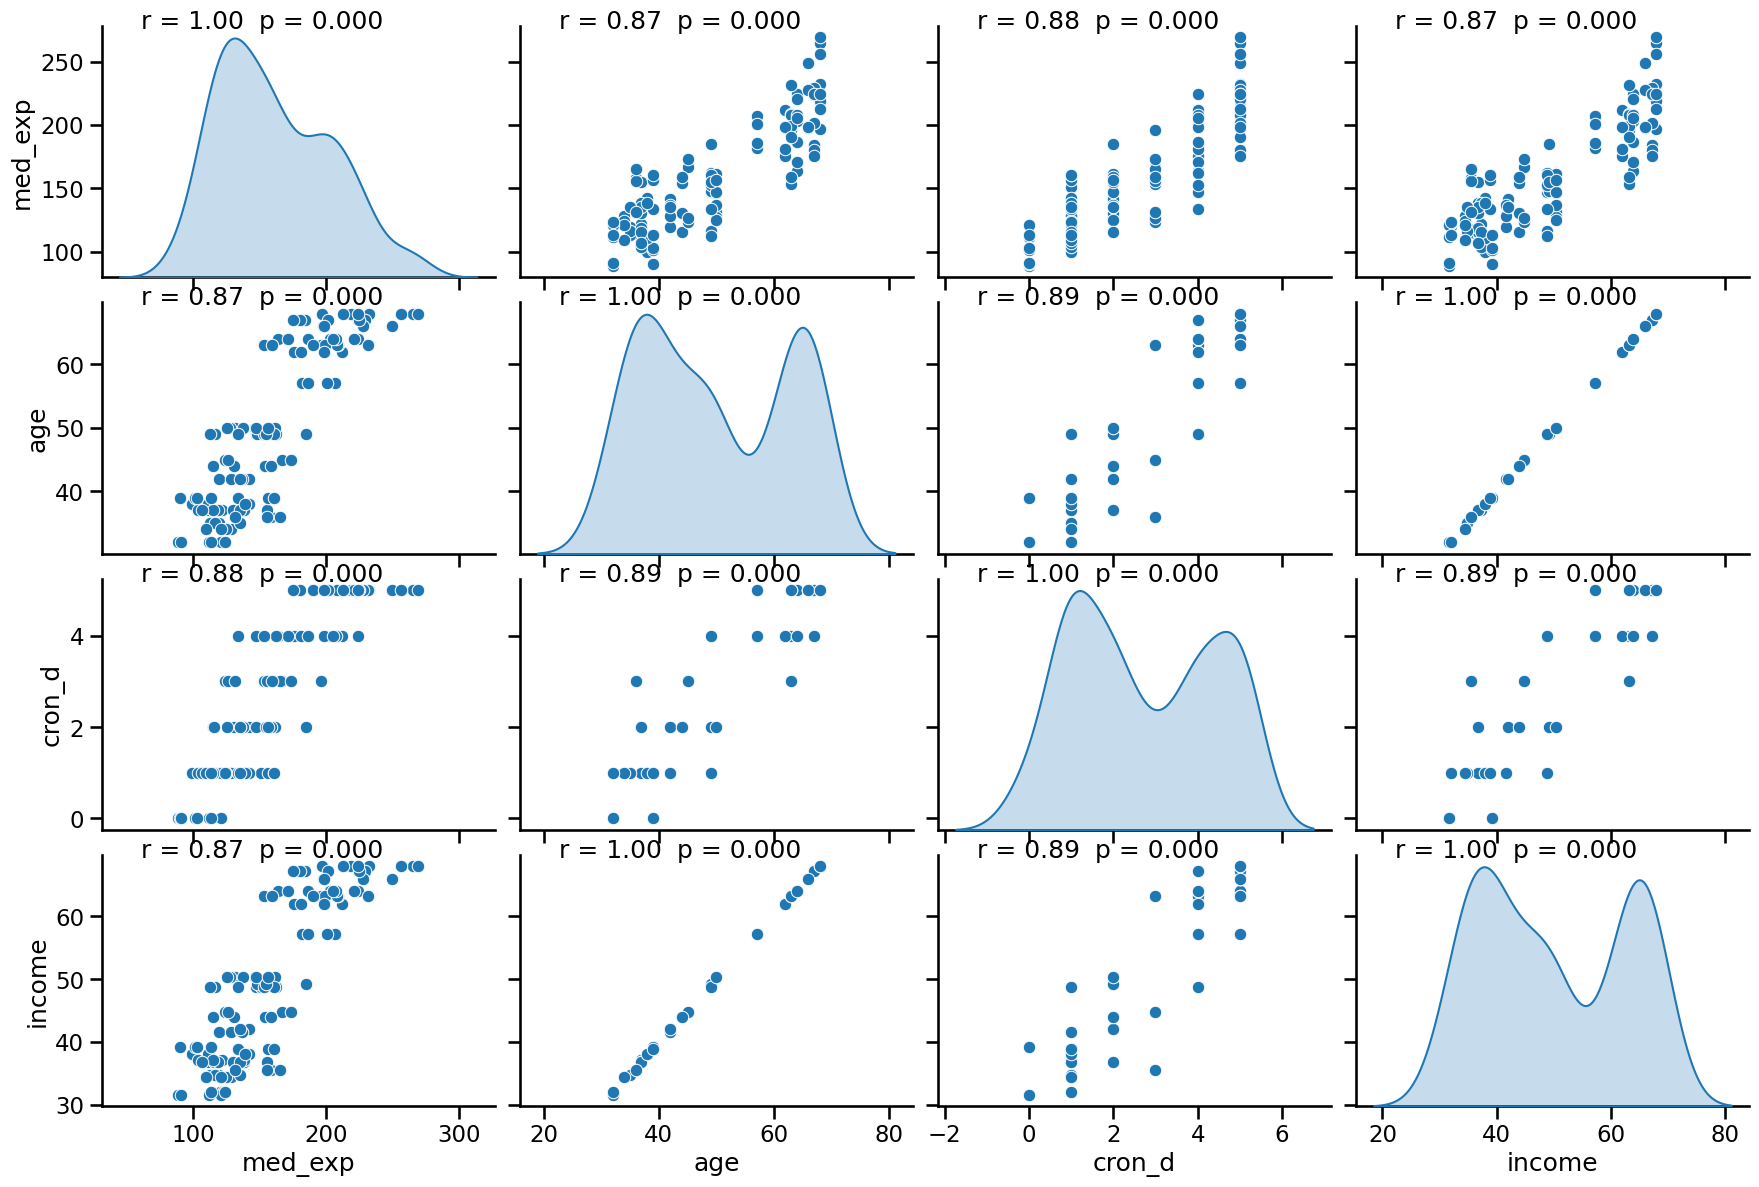

In [17]:
# Corelation between variables (r) and their respective statistical significances (p) along with their scatter plots and kernel density estimate
plt.figure(figsize=(15, 10))
graph = sns.pairplot(df_original.loc[:, "med_exp":"income"], diag_kind="kde", height=3,aspect=1.5)
graph.map(corrfunc)
plt.show()

## Transforming the categorical variable 'plan' into dummy

In [18]:
df = pd.get_dummies(
    df_original, columns=["plan"], drop_first=True,dtype=int
)

df.drop('id',axis=1,inplace=True)

df.head()

,med_exp,age,cron_d,income,plan_emerald,plan_gold
0,206.84,57,5,57.200001,0,0
1,184.19,67,4,67.199997,0,0
2,175.68,62,4,62.000000,0,0
3,180.04,67,5,67.199997,0,0
4,218.86,68,5,68.000000,0,0


## Multicollinearity Diagnose (Variance Inflation Factor and Tolerance)

Multicollinearity is the consequence of the existence of high correlation between two or more explanatory (predictor) variables.

If VIF is greater than 5, then the explanatory variable in question is highly collinear with the other explanatory variables, and the parameter estimates of the model will have large standard errors because of this.

tolerance = 1/VIF

In [19]:
multicollinearity_diagnose(df,target)

Multicollinearity detected for variables: age-income. VIF: 3710.7. VIF threshold: 5. Tolerance: 0.000


### <font color='red'> Note that the variables *income* and *age* present multicolinearity, so they can not be both present on the final model. </font>

## Estimation of a multiple regression model

In [20]:
# Write the formula for the model
explanatory_variables = [col for col in df.columns if col != target]
formula = " + ".join(explanatory_variables)
formula = target + " ~ " + formula
print("Formula: ", formula)

Formula:  med_exp ~ age + cron_d + income + plan_emerald + plan_gold


In [21]:
# Fit the OLS model
model_ols = sm.OLS.from_formula(
    formula=formula, data=df
).fit()

# Sumarry of the model
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                med_exp   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     262.3
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           2.88e-84
Time:                        18:00:07   Log-Likelihood:                -828.04
No. Observations:                 200   AIC:                             1668.
Df Residuals:                     194   BIC:                             1688.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      148.8596     12.744     11.681      0.000     123.725     173.994
age              8.9226      5.549      1.608      0.109      -2.021      19.866
cron_d           6.7232      1.600      4.201      0.000       3.567       9.879
income          -8.4425      5.464     -1.545      0.124     -19.219       2.334
plan_emerald   -35.0189      4.685     -7.474      0.000     -44.259     -25.779
plan_gold      -58.7653      6.075     -9.673      0.000     -70.747     -46.783
==============================================================================
Omnibus:                       25.070   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.329
Skew:                           0.622   Prob(JB):                     3.20e-11
Kurtosis:                       5.062   Cond. No.                         964.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### <font color='red'>Note that the variables *income* and *age* do not present p-values lower than the significance level (5%) and, therefore, they are not statistically significant and should be removed by the use of a stepwise method. They also present multicollinearity, so one of them had to be removed anyway.</font>

## Stepwise procedure

### Removing the variable with the highest p-value (income) and check if age is now significant

In [22]:
# Removing the variable with the highest p-value (income) and check if age is now significant
explanatory_variables = [col for col in df.columns if col != target and col != 'income']
formula = " + ".join(explanatory_variables)
formula = target + " ~ " + formula
print("Formula: ", formula)

Formula:  med_exp ~ age + cron_d + plan_emerald + plan_gold


In [23]:
# Fit the OLS model
model_ols = sm.OLS.from_formula(
    formula=formula, data=df
).fit()

# Sumarry of the model
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                med_exp   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     325.0
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           4.89e-85
Time:                        18:00:07   Log-Likelihood:                -829.26
No. Observations:                 200   AIC:                             1669.
Df Residuals:                     195   BIC:                             1685.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      153.5746     12.417     12.368      0.000     129.085     178.064
age              0.3561      0.225      1.583      0.115      -0.088       0.800
cron_d           7.2704      1.566      4.642      0.000       4.182      10.359
plan_emerald   -34.9918      4.702     -7.442      0.000     -44.265     -25.719
plan_gold      -59.0862      6.093     -9.697      0.000     -71.103     -47.069
==============================================================================
Omnibus:                       28.603   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.043
Skew:                           0.688   Prob(JB):                     2.49e-13
Kurtosis:                       5.252   Cond. No.                         663.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### <font color='red'> Age's p-value is still not significant, so it will also be removed from the model </font>

In [24]:
# Age's p-value is still not significant, so it will also be removed from the model

formula = "med_exp ~ cron_d + plan_emerald + plan_gold"
print("Final model: ", formula)

# Fit the OLS model
model_ols = sm.OLS.from_formula(
    formula=formula, data=df
).fit()

# Sumarry of the model
model_ols.summary()

Final model:  med_exp ~ cron_d + plan_emerald + plan_gold


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                med_exp   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     429.1
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           7.53e-86
Time:                        18:00:07   Log-Likelihood:                -830.54
No. Observations:                 200   AIC:                             1669.
Df Residuals:                     196   BIC:                             1682.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      170.4948      6.345     26.869      0.000     157.981     183.009
cron_d           8.5833      1.334      6.436      0.000       5.953      11.213
plan_emerald   -38.5561      4.143     -9.305      0.000     -46.728     -30.385
plan_gold      -63.8897      5.304    -12.045      0.000     -74.351     -53.429
==============================================================================
Omnibus:                       29.826   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.963
Skew:                           0.707   Prob(JB):                     3.51e-14
Kurtosis:                       5.331   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Verify the adherence of residuals to normal distribution (Shapiro-Francia normality test)

Shapiro-Francia Test Hypothesis:
* H0: Adherence to normal distribution
* H1: Does not present adherence to normal distribution

If the residuais do not present a normal distribution, the Box-Cox transformation has to be performed on the target variable

In [25]:
shap_test = shapiroFrancia(model_ols.resid)

if shap_test['p-value'] <= alpha:
    print(f'Reject H0. The residuals are not normally distributed. p-value:{shap_test["p-value"]:0.2f}')
else:
    print(f'Do not Reject H0. The residuals are normally distributed. p-value:{shap_test["p-value"]:0.2f}')


Reject H0. The residuals are not normally distributed. p-value:0.00


### <font color='red'>Since the residuals are not normally distributed, we apply the box-cox transformation on the target variable so that it will have a distribution resambling normality and hence the residuals too.</font>

## Box-Cox Transformation


* $y^* = (y^\lambda - 1)/\lambda$
* when $\lambda=0, y^*=ln(y)$

In [26]:
target_bc = target + '_bc'
df[target_bc], lambda_bc = boxcox(df[target])

print(f"Lambda for Box-Cox transformation: {lambda_bc:.3f}")

Lambda for Box-Cox transformation: -0.144


In [27]:
df.head()

,med_exp,age,cron_d,income,plan_emerald,plan_gold,med_exp_bc
0,206.84,57,5,57.200001,0,0,3.718813
1,184.19,67,4,67.199997,0,0,3.664649
2,175.68,62,4,62.000000,0,0,3.642295
3,180.04,67,5,67.199997,0,0,3.653899
4,218.86,68,5,68.000000,0,0,3.744867


## New model with the box-cox transformed target

In [28]:
# Age's p-value is still not significant, so it will also be removed from the model

formula_bc = "med_exp_bc ~ cron_d + plan_emerald + plan_gold"
print("Final model: ", formula_bc)

# Fit the OLS model
model_ols_bc = sm.OLS.from_formula(
    formula=formula_bc, data=df
).fit()

# Sumarry of the model
model_ols_bc.summary()

Final model:  med_exp_bc ~ cron_d + plan_emerald + plan_gold


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             med_exp_bc   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     539.4
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           2.07e-94
Time:                        18:00:07   Log-Likelihood:                 353.90
No. Observations:                 200   AIC:                            -699.8
Df Residuals:                     196   BIC:                            -686.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.5983      0.017    211.642      0.000       3.565       3.632
cron_d           0.0271      0.004      7.582      0.000       0.020       0.034
plan_emerald    -0.0903      0.011     -8.137      0.000      -0.112      -0.068
plan_gold       -0.1910      0.014    -13.437      0.000      -0.219      -0.163
==============================================================================
Omnibus:                        2.456   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.071
Skew:                          -0.185   Prob(JB):                        0.355
Kurtosis:                       3.333   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Perform again the Shapiro-Francia Test

In [29]:
shap_test = shapiroFrancia(model_ols_bc.resid)

if shap_test['p-value'] <= alpha:
    print(f'Reject H0. The residuals are not normally distributed. p-value:{shap_test["p-value"]:0.2f}')
else:
    print(f'Do not Reject H0. The residuals are normally distributed. p-value:{shap_test["p-value"]:0.2f}')

Do not Reject H0. The residuals are normally distributed. p-value:0.06


### Plot of residuals of both models

The black like pictures normal distribution. The blue line pictures the distribution of the residuals after the Box-Cox transformation.


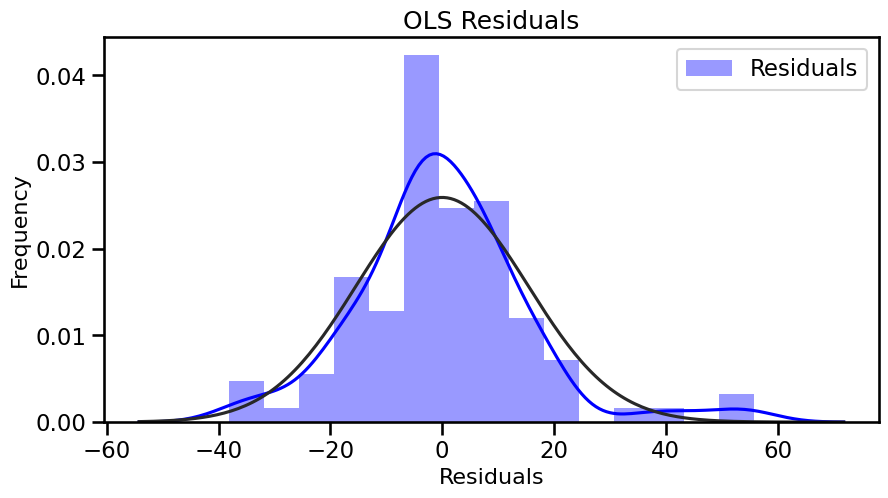

In [30]:
print('The black like pictures normal distribution. The blue line pictures the distribution of the residuals after the Box-Cox transformation.')
plt.figure(figsize=(10, 5))
sns.distplot(model_ols.resid, fit=norm, kde=True, bins=15, color="blue",label='Residuals')
plt.xlabel("Residuals", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("OLS Residuals")
plt.legend()
plt.show()

The black like pictures normal distribution. The red line pictures the distribution of the residuals after the Box-Cox transformation.


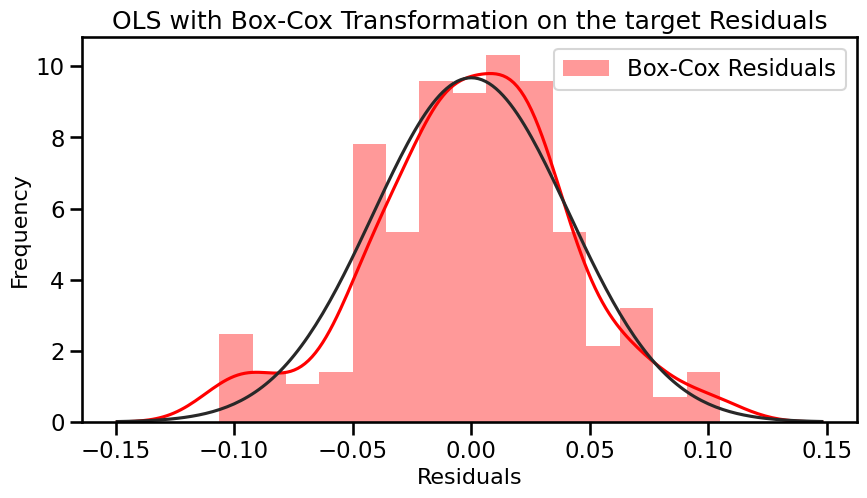

In [37]:


print('The black like pictures normal distribution. The red line pictures the distribution of the residuals after the Box-Cox transformation.')
plt.figure(figsize=(10, 5))
sns.distplot(model_ols_bc.resid, fit=norm, kde=True, bins=15, color="red",label='Box-Cox Residuals')
plt.xlabel("Residuals", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("OLS with Box-Cox Transformation on the target Residuals")
plt.legend()
plt.show()

## Saves the fitted values and residuals on the data frame

In [32]:
# Performs inverse box-cox transformation on the fitted values
y_fitted = inverse_boxcox_transformation(model_ols_bc.fittedvalues,lambda_bc)

df["fitted_values_bc"] = model_ols_bc.fittedvalues
df["fitted_values"] = y_fitted
df["residuals"] = model_ols_bc.resid

In [33]:
df.head()

,med_exp,age,cron_d,income,plan_emerald,plan_gold,med_exp_bc,fitted_values_bc,fitted_values,residuals
0,206.84,57,5,57.200001,0,0,3.718813,3.73371,213.617642,-0.014897
1,184.19,67,4,67.199997,0,0,3.664649,3.70662,201.475699,-0.041972
2,175.68,62,4,62.000000,0,0,3.642295,3.70662,201.475699,-0.064325
3,180.04,67,5,67.199997,0,0,3.653899,3.73371,213.617642,-0.079812
4,218.86,68,5,68.000000,0,0,3.744867,3.73371,213.617642,0.011157


## Heterocedasticity Test on the residuals


Breusch-Pagan Test Hypothesis:
* H0: Absence of heterocedasticity, that is the residuals present homocedasticity.
* H1: Presence of heterocedasticity in the residuals, that is, there is correlation between the residuals and one of more features. This indicates the omission of a relevant variable.

In [34]:
_, p_value_bp_test = breusch_pagan_test(model_ols_bc)

chisq: 1.012628111224215
p-value: 0.47788750037447564
Does not reject H0: There is no heteroscedasticity


## Plot the Residuals

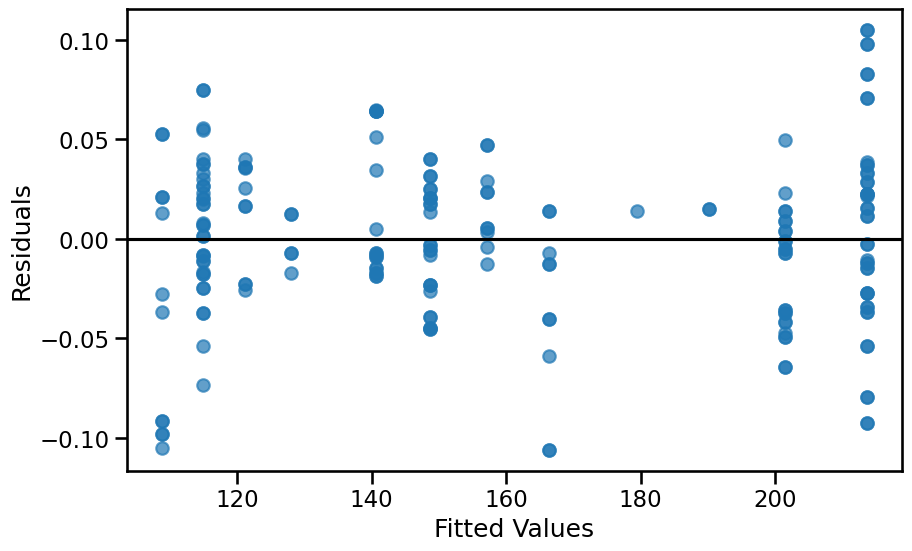

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(df['fitted_values'], df['residuals'], alpha=0.7)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(0,color='black')
plt.show()

# Conclusion

The final OLS model 'med_exp_bc ~ cron_d + plan_emerald + plan_gold' presents:.

* Homocedasticity on the residuals.
* The residuals are normally distributed.
* All the explanatory variables are statistically significant and do not present multicollinearity.

In [44]:
print("Formula:", formula_bc)
# Summary of the final model
model_ols_bc.summary()

Formula: med_exp_bc ~ cron_d + plan_emerald + plan_gold


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             med_exp_bc   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     539.4
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           2.07e-94
Time:                        18:08:44   Log-Likelihood:                 353.90
No. Observations:                 200   AIC:                            -699.8
Df Residuals:                     196   BIC:                            -686.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.5983      0.017    211.642      0.000       3.565       3.632
cron_d           0.0271      0.004      7.582      0.000       0.020       0.034
plan_emerald    -0.0903      0.011     -8.137      0.000      -0.112      -0.068
plan_gold       -0.1910      0.014    -13.437      0.000      -0.219      -0.163
==============================================================================
Omnibus:                        2.456   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.071
Skew:                          -0.185   Prob(JB):                        0.355
Kurtosis:                       3.333   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""